In [2]:
from Simulator import Simulator
from Timer import Timer

with Timer("build_simulator") :
    neuron_network_filename = "Network2"
    simulator = Simulator(neuron_network_filename)
    
with Timer("make_graph_board") :
    simulator.graph.make_graph_board(0)

simulator.boarn()

======================== build_simulator ==========================

Elapsed time : 0.03125000 sec 
======================== make_graph_board ==========================

Elapsed time : 0.00000000 sec 


In [ ]:
debug_config = {"debug_mode":"true"}
simulator.graph.debug_set(debug_config)

In [ ]:
debug_config = {"debug_include":["Inner"]}
simulator.graph.debug_set(debug_config)

In [ ]:
debug_config = {"debug_remove":["Inner/G0/b#0/Ca+"]}
simulator.graph.debug_set(debug_config)

In [ ]:
with Timer("one_step_CPU") :
    for i in range(10000) :
        simulator.one_step()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
a = 0
da =0
b = 0
db = 0

In [12]:
from IPython.display import display
from sympy import Symbol, init_printing, atan, sqrt, exp
init_printing()
x = Symbol('x')
f = 1/(x+1)
f_taylor = f.series(x, x0=0, n=6)
display(f_taylor)

In [14]:
f_taylor

In [1]:
import networkx as nx
import numpy as np
import math
import numpy as np
import time
import matplotlib.pyplot as plt

def tayler(c_arr,x):
    c_list = c_arr
    c_list.reverse()
    y = 1
    for c in c_list :
        y = c[0]*y*x + c[1]

    return y

def rel(x,dx,parm):
    R =tayler([(parm[0],parm[1])],x)
    D = tayler([(parm[2],parm[3])],x)
    return R*dx + D*dt

def graph_show(G) :
    pos = nx.spring_layout(G)
    nx.draw(G,pos, cmap = plt.get_cmap('jet'))
    nx.draw_networkx_labels(G, pos)
    plt.show()
    plt.clf()
    
def show_history(value, node_list,vdv):
    fig = plt.figure()
    node_num = len(node_list)
    axv = [0 for j in range(node_num)]
    for i in range(node_num):
        axv[i] = fig.add_subplot(node_num,1,i+1)
    for i,node in enumerate(node_list) :
        axv[i].plot(value[node]["history"][vdv])
        axv[i].set_ylabel(node)
    plt.show()
    plt.clf()

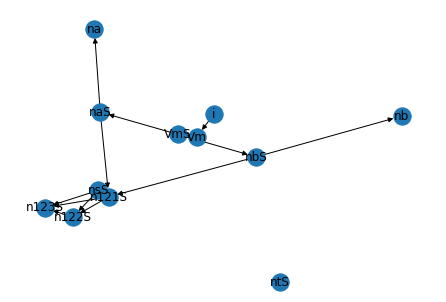

<Figure size 432x288 with 0 Axes>

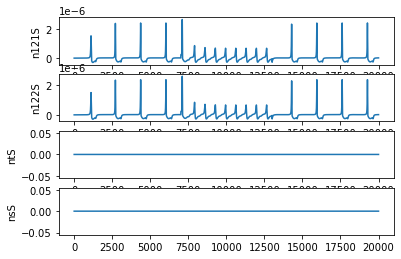

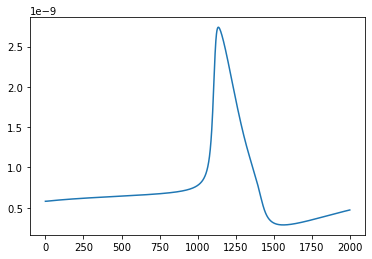

In [34]:

T = 100
dt = 1/T
WT = T*200
value = {}
e = math.e

#I_input = np.zeros(WT)
#I_input[70*T:130*T]=dt
Vm = np.load('../temp/huxley/value/vm.npy')
I_input = Vm

NG = nx.DiGraph()
NG.add_node("Vm", init =0)
NG.add_node("VmS", init =0)
NG.add_node("na", init =0.0058)
NG.add_node("naS", init =0.0000058)
NG.add_node("nb", init =0.1249)
NG.add_node("nbS", init =0.00001249)
NG.add_node("n121S", init =0.00001829)
NG.add_node("n122S", init =0.00001829+0.0000317)
NG.add_node("n123S", init =0.00001829*0.0000317)
NG.add_node("ntS", init =0.0000058-0.00001829*0.317)
NG.add_node("nsS", init =0.0000317)
NG.add_node("i", init =0)
NG.add_edge("i","Vm",parm=[0,1,0,0])
NG.add_edge("Vm","VmS",parm=[0,0.00001,0,0])

x_d1 = 100/((e-1)*(e-1))
x_d0 = 0.1/(e-1)

NG.add_edge("VmS","naS",parm=[x_d1,x_d0,0,0])
NG.add_edge("naS","na",parm=[0,10000,0,0])

x_d1 = 125/80
x_d0 = -1/80

NG.add_edge("VmS","nbS",parm=[x_d1,x_d0,0,0])
NG.add_edge("nbS","nb",parm=[0,10000,0,0])

NG.add_edge("nbS","n121S",parm=[0,1,0,0])
NG.add_edge("naS","n121S",parm=[0,1,0,0])
NG.add_edge("n121S","n122S",parm=[-1,1,0,0])
NG.add_edge("nsS","n122S",parm=[-1,1,0,0])
NG.add_edge("n122S","n123S",parm=[1,1,0,0])
NG.add_edge("n121S","n123S",parm=[0,-1,0,0])
NG.add_edge("nsS","n123S",parm=[0,-1,0,0])
#NG.add_edge("naS","ntS",parm=[0,1,0,0])
#NG.add_edge("n123S","ntS",parm=[0,-10000,0,0])
#NG.add_edge("ntS","nsS",parm=[0,0,1,0])
#NG.add_edge("IN","t",parm=[0,-1,0,0])
#NG.add_edge("t","IN",parm=[0,0,0.1,0.05*dt])


n_list = NG.nodes()
#regist value
for node in NG.nodes(data="init") :
    value[node[0]] = {"v":node[1],"dv":0,"ndv":0,"history":{"v":[node[1]], "dv":[0]}}

for i in range (WT):
    
    # dv change
    for edge in NG.edges(data="parm"):
        dvplus = rel(value[edge[0]]["v"],value[edge[0]]["ndv"],edge[2])
        value[edge[1]]["dv"] += dvplus
        #value[edge[0]]["dv"] -= dvplus
        
        
    # value change
    for node in value:
        value[node]["v"] += value[node]["dv"]
        # history apepnd
        value[node]["history"]["v"].append(value[node]["v"])
        value[node]["history"]["dv"].append(value[node]["dv"])
        # ndv update
        value[node]["ndv"]= value[node]["dv"]
        # dv init
        value[node]["dv"]=0
    
    # input
    value["i"]["dv"] = I_input[i] -value["i"]["v"]
    
    
graph_show(NG)
show_history(value,["n121S","n122S","ntS","nsS"],"dv")

na_answer = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
nb_answer = .125*np.exp(-Vm/80)
ns_answer =  np.load('../temp/huxley/value/ns.npy')
nt_answer = ns_answer[1:] - ns_answer[:-1]

v = (np.array((value['n121S']['history']["v"]))*np.array(value['nsS']['history']["v"]))[:2001]
dv = v[1:]-v[:-1]

plt.plot(v)
#plt.plot(value['n123S']['history']["v"][:2000])

#plt.plot((np.array((value['n121S']['history']["v"]))*np.array(value['nsS']['history']["v"]))[:100])
#plt.plot(value['n123S']['history']["dv"][:1000])




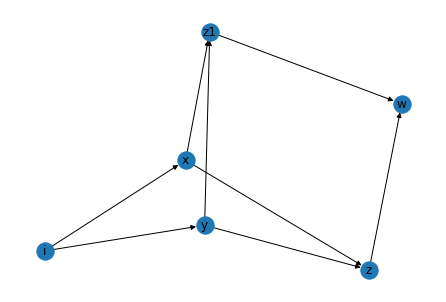

<Figure size 432x288 with 0 Axes>

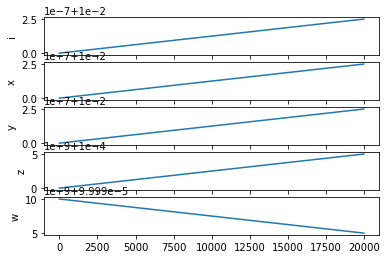

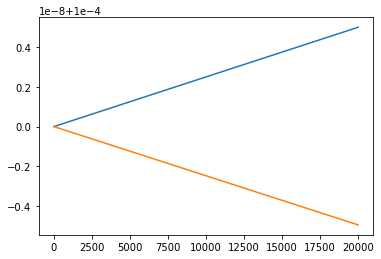

In [65]:

T = 100
dt = 1/T
WT = T*200
value = {}
e = math.e

I_input = np.arange(WT)/(WT*4000000)+1/100

NG = nx.DiGraph()
NG.add_node("i", init =1/100)
NG.add_node("x", init =1/100)
NG.add_node("y", init =1/100)
NG.add_node("z", init =1/10000)
NG.add_node("z1", init =1/10000)
NG.add_node("w", init =1/10000)

NG.add_edge("i","x",parm=[0,1,0,0])
NG.add_edge("i","y",parm=[0,1,0,0])
NG.add_edge("x","z",parm=[1,0,0,0])
NG.add_edge("y","z",parm=[1,0,0,0])
NG.add_edge("x","z1",parm=[0,1,0,0])
NG.add_edge("y","z1",parm=[0,1,0,0])
NG.add_edge("z1","w",parm=[1,0,0,0])
NG.add_edge("z","w",parm=[0,-1,0,0])


n_list = NG.nodes()
#regist value
for node in NG.nodes(data="init") :
    value[node[0]] = {"v":node[1],"dv":0,"ndv":0,"history":{"v":[node[1]], "dv":[0]}}

for i in range (WT):
    
    # dv change
    for edge in NG.edges(data="parm"):
        dvplus = rel(value[edge[0]]["v"],value[edge[0]]["ndv"],edge[2])
        value[edge[1]]["dv"] += dvplus
        #value[edge[0]]["dv"] -= dvplus
        
        
    # value change
    for node in value:
        value[node]["v"] += value[node]["dv"]
        # history apepnd
        value[node]["history"]["v"].append(value[node]["v"])
        value[node]["history"]["dv"].append(value[node]["dv"])
        # ndv update
        value[node]["ndv"]= value[node]["dv"]
        # dv init
        value[node]["dv"]=0
    
    # input
    value["i"]["dv"] = I_input[i] -value["i"]["v"]
    
    
graph_show(NG)
show_history(value,['i','x','y','z','w'],"v")


plt.plot(np.array(value['x']['history']["v"])*np.array(value['y']['history']["v"]))
plt.plot(np.array(value['w']['history']["v"]))

In [42]:
value['w']['history']["v"][5]

-2.5e-08

In [44]:
value['w']['history']["v"][5]

0.0

In [23]:
I_input

array([0.0000e+00, 2.0000e-04, 4.0000e-04, ..., 3.9994e+00, 3.9996e+00,
       3.9998e+00])

In [16]:
value['IN']['history']["v"][-2000:]

KeyError: 'IN'

In [17]:
ns_answer =  np.load('../temp/huxley/value/ns.npy')

In [62]:
ns_answer[0]

0.3176769140606974

In [388]:
nb_answer[0]

0.12497816283637182

In [238]:
NG = nx.DiGraph()
NG.add_node("x", v=1*dt,dv=0,ndv=0)
NG.add_node("y", v=0,dv=0,ndv=0)
NG.add_node("z", v=0,dv=0,ndv=0)
NG.add_node("i", v=0,dv=0,ndv=0)
NG.add_edge("i","x",parm=[0,-1,1,dt])

NG.nodes(data="v")['i']


0

In [245]:
for node in NG.nodes(data="init") :
    print(node[1])

0
0
0
0


In [111]:
dt = 1/100
def tayler(c_arr,x):
    c_list = c_arr
    c_list.reverse()
    y = 1
    for c in c_list :
        y = c[0]*y*x + c[1]

    return y
        


def a_to_b(x,dx):
    R =tayler([(0,-2)],x)
    D = tayler([(0.1,0.05*dt)],x)
    return R*dx + D*dt

def b_to_a(x,dx):
    R = 0
    D = tayler([(0.1,0.05*dt)],x)
    return R*dx + D*dt

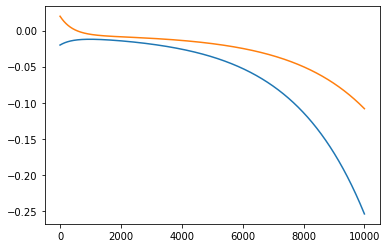

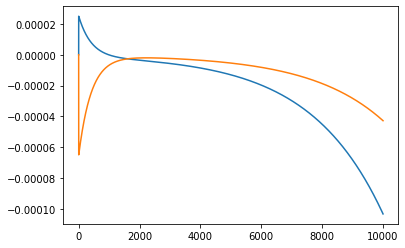

In [112]:
WT =10000

a= -2*dt
b= 2*dt
c= 0
d= 0
da = 0
db = 0
dc = 0
dd = 0
sda = 0
sdb = 0
sdc = 0
sdd = 0
history = [[a],[b],[c],[d],[da],[db],[dc],[dd]]
#a_input = np.arange(WT)/(50*WT)
#b_input = np.arange(WT)/(50*WT)
answer = []



for i in range (WT):
    
    db+= a_to_b(a,sda)
    da+= b_to_a(b,sdb)
    #dd+= c_to_d(c,dc)
    #dd+= a_to_d(a,da)
    #dd+= b_to_d(b,db)
    #da =b_to_a(b,db)
    a = a+da
    b = b+db
    #c = c+dc
    #d = d+dd
    history[0].append(a)
    history[1].append(b)
    #history[2].append(c)
    #history[3].append(d)
    history[4].append(da)
    history[5].append(db)
    #history[6].append(dc)
    #history[7].append(dd)
    answer.append(a*b)
    sda = da
    sdb = db
    da = 0
    db = 0
    
    #da = a_input[i] -a
    #db = b_input[i] -b
    
    
    
plt.clf()
plt.plot(history[0])
plt.plot(history[1])
#plt.plot(history[2])
#plt.plot(history[3])
#plt.plot(answer)
plt.show()

plt.plot(history[4])
plt.plot(history[5])
#plt.plot(history[6])
#plt.plot(history[7])
plt.show()

In [ ]:
history[0][-2]

In [ ]:
import numpy as np
 
a = np.sin(np.arange(0, 5, 0.001))
b = np.sin(np.arange(0, 5, 0.001))

In [ ]:
a.shape

In [ ]:
import numpy as np
 
a = np.full((400,200),2 dtype=float)
b = np.full((200,400),1, dtype=float)
c = np.full((200,400),0, dtype=float)
from scipy.sparse import csr_matrix
d = csr_matrix(c)
with Timer("test_np") :
    for i in range(10000) :
        e=d.dot(a)
        #d=a*b

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
from numba import njit

In [ ]:

def dot_py(A,B):
    m, n = A.shape

    C = np.zeros((m,n))
    
    for i in range(100000):
        for i in range(0,m):
            for j in range(0,n):
                C[i,j] = A[i,j]*B[i,j] 
    return C

import numba as nb
dot_nb = nb.jit(nopython=True)(dot_py)

In [ ]:
a = np.full((200,100),2, dtype=float)
dot_nb(a,a)
with Timer("test_np") :
    dot_nb(a,a)

In [ ]:
def dot_py2(A,B):
    for i in range(100000):
        C=A*B
    return C
    
 
a = np.full((200,100),2, dtype=float)
with Timer("test_np") :
    dot_py2(a,a)

In [ ]:
c

In [ ]:
%timeit  test1()
%timeit  test2()

In [ ]:
plt.plot(tt)
plt.show()

In [ ]:
np.__version__

In [ ]:
e.shape

In [ ]:
simulator.graph.debug_dict

In [ ]:
simulator.graph.debug_show

In [ ]:
simulator.neuron_element.Utill.RDF_function

In [ ]:
with Timer("one_step_CPU") :
    for i in range(1) :
        simulator.one_step()

In [ ]:
simulator.graph.hierarchical_graph['neuron_element'].node_dict['Inner/G0/c#0/@Input~Local~Spike']

In [ ]:
simulator.graph.hierarchical_graph['neuron_model'].node_dict['Inner/G0/c#0']

In [ ]:
len(simulator.graph.hierarchical_graph["neuron_model"].node_dict)

In [ ]:
import numpy as np
a = [[1,2,3],[1,2,3]]
b = np.array(a)

In [ ]:
b.shape

In [ ]:
c = b[0]

In [ ]:
c = c+np.array([1,1,1])

In [ ]:
b[0] = np.array([4,5,6])

In [ ]:
b

In [ ]:
import json
json.dump(b)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
simulator.graph.debug_visualization(50, "Inner/G0/c#0/NMDAR")

In [ ]:
simulator.graph.hierarchical_up_group_dict

In [ ]:
for neuron_model_label in simulator.graph.hierarchical_graph["neuron_model"].node_dict:
    neuron_model = simulator.graph.node_label_dict[neuron_model_label]
    print(neuron_model["label"] +"\t\t"+ str(neuron_model["local_synaps_num"])) 

In [ ]:
for neuron_element_label in simulator.graph.hierarchical_graph["neuron_element"].node_dict:
    neuron_element = simulator.graph.node_label_dict[neuron_element_label]
    print(neuron_element["label"] +"\t\t"+ str(neuron_element["synaps_num"])) 

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].edge_dict

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["Inner/G0/a#0"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["LIF Trainer/G0/a#0"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_dict["LIF Trainer/G0/a#0/@Input~Global~Spike"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_dict["LIF Trainer/G0/a#0/Inner"]

In [ ]:
simulator.graph.job_list

In [ ]:
import numpy as np
a = np.array([[0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. ]])

np.array([sum(a[:,6])])

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["LIF Trainer/G0/a#0"]

In [ ]:
simulator.graph.global_input_job_list

In [ ]:
a

In [ ]:
simulator.graph.debug_by_networkx()

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_from_dict

In [ ]:
import random
random.randint(2,5)

In [ ]:
import numpy as np
a = np.array([[1,2],[3,4]])

In [ ]:
b = np.array([[1,2],[3,4]])

In [ ]:
np.zeros(a.shape)

In [ ]:
a = np.array([1,2])

In [ ]:
a = np.array([a])

In [ ]:
a

In [ ]:
b*a

In [ ]:
np.dot(a,b)

In [ ]:
c = np.delete(a,[2,3],0)

In [ ]:
log(a)

In [ ]:
c

In [ ]:
import numpy as np
a ={1: np.array([1,2,3,4])}
b = {1: np.array([10])}
c ={1: np.array([1,2,3,4])}

In [ ]:
d=a.get(1)

In [ ]:
a[1] = b[1]

In [ ]:
d

In [ ]:
b[1] = np.array([20])

In [ ]:
a =np.array([1,2,3,4,25])
b =np.array([15])
c = a&b

In [ ]:
c

In [ ]:
b

In [ ]:
for v, id in enumerate(a):
    print(v)
    print(id)

In [ ]:
import numpy as np

In [ ]:
a = {1:{1:1}}
b=a[1]
b[1]=2
a

In [ ]:
len(a)

In [ ]:
import pycuda.driver as cuda

In [ ]:
a = np.array([])

In [ ]:
a = np.concatenate((a, np.array(['ㅁ'])))
print(a)

In [ ]:
np.where(a==0)[0]

In [ ]:
import time
a = {1:1}
b=0

#a={}


whole_time0 = 0
whole_time1 = 0
whole_time2 = 0

for i in range(1000000) :
    
    start1 = time.time()
    
    for k in a :
        b=b+a[k]
        break
    
    
    end1 = time.time()
    whole_time1 = whole_time1+end1 - start1
    
    
    start2 = time.time()
    
    if len(a)==1 :
        b=b+list(a.values())[0]
    
    
    end2 = time.time()
    whole_time2 = whole_time2+end2 - start2
    
    start0 = time.time()
    end0 = time.time()
    whole_time0 = whole_time0+end0 - start0

print(whole_time1 - whole_time0)
print(whole_time2 - whole_time0)

In [ ]:
neuron_network.graph.hierarchical_graph["neuron_model"].node_dict

In [ ]:
a = {1:'1',2:'2'}
b=a
a[3]='3'
next(iter(a))

In [ ]:
a={}
next(iter(a))

In [ ]:
iter(a)

In [ ]:
a = {1:'1'}
next(iter(a))

In [ ]:
c = dict(a)
c.update(b)
c

In [ ]:
neuron_network.graph.hierarchical_graph["neuron_group"].node_dict

In [ ]:
from random import *
random()

In [ ]:
NeuralNetwork.graph.hierarchical_graph['neuron_model'].node_dict['Inner@1\\n0\\Na+ Channel']["neuron_model"].neuron_node

In [ ]:
import random
import time
import timeit
start = timeit.timeit() 

time.sleep(1)

a = random.random()


print(timeit.timeit() - start)

In [ ]:
import timeit




t1 = timeit.timeit(lambda: "-".join(map(str, range(100))), number=10000)
print(t1)


In [ ]:
NeuralNetwork.network_json

In [ ]:
NeuralNetwork.graph.node_label_dict

In [ ]:
NeuralNetwork.graph.hierarchical_group_dict

In [ ]:
NeuralNetwork.graph.hierarchical_graph['neuron'].edge_dict

In [ ]:
NeuralNetwork.makeInitNeuron()

In [ ]:
NeuralNetwork.neuron_graph.node_dict

In [ ]:
NeuralNetwork.network_json

In [ ]:
NeuralNetwork.neuron_group_dict['Inner@1'].neuron_dict[0].edges

In [ ]:
layer1 = {'nodes':[1,2,3], 'edges':[(1,2),(2,3)]}
layer2 = {'nodes':[1,2,3], 'edges':[(1,2),(1,2)]}
layer3 = {'nodes':[1,2], 'edges':[(1,2)]}
layer4 = {'nodes':[1,2,3,4], 'edges':[(1,2),(1,3),(1,4)]}

In [ ]:
from Graph import Graph

testGraph = Graph()

testNodeB = [1,2,3,4,5,6,7,8]
testEdgeB = [(2,1), (3,1),(4,1),(1,5),(1,6),(1,7), (4,7)]

testNodeA = []
for node in testNodeB :
    testNodeA.append({'label':node})
    
testEdgeA = []
id = 0
for edge in testEdgeB :
    testEdgeA.append({'from':edge[0], 'to':edge[1], 'label':id})
    id = id+1

In [ ]:
testNodeA

In [ ]:
testEdgeA

In [ ]:
testGraphA = {"nodes":testNodeA, "edges":testEdgeA}

In [ ]:
testGraph.initGraph(testGraphA)

In [ ]:
testGraph.deleteNode({'label':1})

In [ ]:
testGraph.node_dict

In [ ]:
testGraph.edge_dict

In [ ]:
testGraph.node_from_dict

In [ ]:
testGraph.node_to_dict

In [ ]:
import networkx as nx

In [ ]:
def R(x) :
    return 0
    #return x/2

def D(x) :
    return x/2

import numpy as np
dt = 1/100
T = 10

SL = int(T/dt)

a = np.sin(np.arange(0, T, dt))
da = np.full((SL,),dt, dtype=float)
b = np.full((SL,),0, dtype=float)
db = np.full((SL,),0, dtype=float)

for i in range (SL) :
    da[i] = a[i]-a[i-1]
    db[i] = R(a[i])*da[i] + D(a[i])*dt
    b[i] = b[i-1]+db[i]
    
ans = np.square(a)/4

In [ ]:
from matplotlib import pyplot as plt

plt.plot(a)
plt.plot(da)
plt.plot(b)
plt.plot(db)
plt.legend(['a','da','bd','db'])
plt.show()

plt.plot(a)
plt.plot(da)
plt.plot(ans)
plt.plot(db)
plt.legend(['a','da','ans','db'])
plt.show()

plt.plot(a)
plt.plot(da)
plt.plot(b)
plt.plot(ans)
plt.plot(db)
plt.legend(['a','da','b','ans','db'])
plt.show()